In [ ]:
# Chapter 6 학습 관련 기술들

In [9]:
import sys
sys.path.append('..')
from np import *

In [10]:
#6.1.2 확률적 경사 하강법(SGD)

class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr

    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]


In [ ]:
network = TwoLayerNet(...)
optimizer = SGD()

for i in range(10000):
    ...
    x_batch, t_batch = get_mini_batch(...)    # 미니배치
    grads = network.gradient(x_batch, t_batch)
    params = network.params
    optimizer.update(params, grads)
    ...

In [11]:
#6.1.4 모멘텀

class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None

    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)

        for key in params.keys():
            self.v[key] = self.momentum * self.v[key] - self.lr * grads[key]
            params[key] += self.v[key]


In [12]:
#6.1.5 AdaGrad

class AdaGrad:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None

    def update(self, params, grads):
        if self.h is None:
            self.h = {}

            for key, val in params.items():
                self.h[key] = np.zeros_like(val)

        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

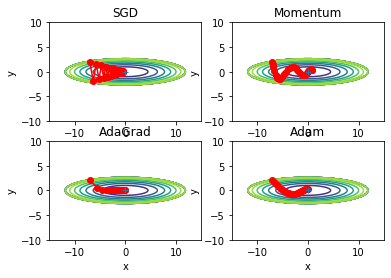

In [33]:
# 6.1.7 어느 갱신 방법을 이용할 것인가?

import sys, os
sys.path.append(os.pardir) 
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from common.optimizer import *


def f(x, y):
    return x**2 / 20.0 + y**2


def df(x, y):
    return x / 10.0, 2.0*y

init_pos = (-7.0, 2.0)
params = {}
params['x'], params['y'] = init_pos[0], init_pos[1]
grads = {}
grads['x'], grads['y'] = 0, 0


optimizers = OrderedDict()
optimizers["SGD"] = SGD(lr=0.95)
optimizers["Momentum"] = Momentum(lr=0.1)
optimizers["AdaGrad"] = AdaGrad(lr=1.5)
optimizers["Adam"] = Adam(lr=0.3)

idx = 1

for key in optimizers:
    optimizer = optimizers[key]
    x_history = []
    y_history = []
    params['x'], params['y'] = init_pos[0], init_pos[1]
    
    for i in range(30):
        x_history.append(params['x'])
        y_history.append(params['y'])
        
        grads['x'], grads['y'] = df(params['x'], params['y'])
        optimizer.update(params, grads)
    
    #범위를 -15~15로 지정 후 비교
    x = np.arange(-15, 15, 0.01)
    y = np.arange(-5, 5, 0.01)
    
    X, Y = np.meshgrid(x, y) 
    Z = f(X, Y)
    
    mask = Z > 7
    Z[mask] = 0
    
    plt.subplot(2, 2, idx)
    idx += 1
    plt.plot(x_history, y_history, 'o-', color="red")
    plt.contour(X, Y, Z)
    plt.ylim(-10, 10)
    plt.xlim(-15, 15)
    plt.plot(0, 0, '+')
    plt.title(key)
    plt.xlabel("x")
    plt.ylabel("y")
    
plt.show()

===========iteration:0===========
SGD:2.3230825344156534
Momentum:2.326369233165933
AdaGrad:1.9183817239455452
Adam:2.1877943682657266
===========iteration:100===========
SGD:1.6243851019312847
Momentum:0.44939312965592915
AdaGrad:0.21579738445996363
Adam:0.3749350097996086
===========iteration:200===========
SGD:0.7613493215866214
Momentum:0.25943871506729743
AdaGrad:0.10385139238787697
Adam:0.2233713940538615
===========iteration:300===========
SGD:0.5351192964895053
Momentum:0.1437891818156936
AdaGrad:0.0412198444348065
Adam:0.09482033773003563
===========iteration:400===========
SGD:0.5814702834574798
Momentum:0.2878727307448664
AdaGrad:0.14030286488148205
Adam:0.2682548884805006
===========iteration:500===========
SGD:0.4212206730873402
Momentum:0.19590731835874586
AdaGrad:0.13286251391876241
Adam:0.13730911102920887
===========iteration:600===========
SGD:0.34414610921401884
Momentum:0.1433399455648034
AdaGrad:0.09434046289993858
Adam:0.1385428381020966
===========iteration:700==

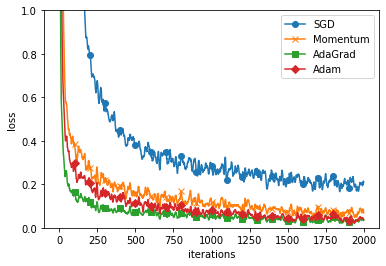

In [35]:
# 6.1.8 MNIST 데이터셋으로 본 갱신 방법 비교
import os
import sys
sys.path.append(os.pardir)  
import matplotlib.pyplot as plt
from mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import *


(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['AdaGrad'] = AdaGrad()
optimizers['Adam'] = Adam()

networks = {}
train_loss = {}
for key in optimizers.keys():
    networks[key] = MultiLayerNet(
        input_size=784, hidden_size_list=[100, 100, 100, 100],
        output_size=10)
    train_loss[key] = []    


for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print( "===========" + "iteration:" + str(i) + "===========")
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))

markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D"}
x = np.arange(max_iterations)
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.show()

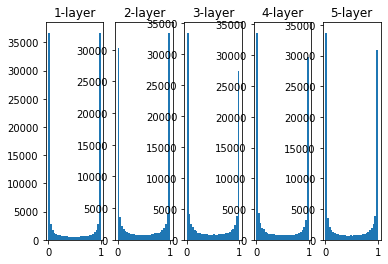

In [15]:
#6.2.2 은닉층의 활성화값 분포

import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1 / (1 + np.exp(-x))


x = np.random.randn(1000, 100)  # 1000개의 데이터
node_num = 100  # 각 은닉층의 노드 수
hidden_layer_size = 5  # 은닉층이 5개
activations = {}  # 활성화값을 저장

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
    w = np.random.randn(node_num, node_num) * 1
    a = np.dot(x, w)
    z = sigmoid(a)
    activations[i] = z
    
# 히스토그램 그리기
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    plt.hist(a.flatten(), 30, range=(0, 1))

plt.show()

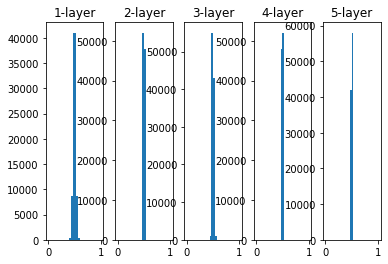

In [16]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


x = np.random.randn(1000, 100)  # 1000개의 데이터
node_num = 100  # 각 은닉층의 노드 수
hidden_layer_size = 5  # 은닉층이 5개
activations = {}  # 활성화값을 저장

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
    #w = np.random.randn(node_num, node_num) * 1
    w = np.random.randn(node_num, node_num) * 0.01
    a = np.dot(x, w)
    z = sigmoid(a)
    activations[i] = z
    
# 히스토그램 그리기
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    plt.hist(a.flatten(), 30, range=(0, 1))

plt.show()

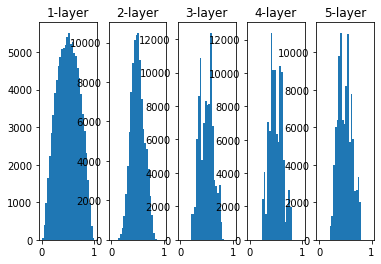

In [17]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

x = np.random.randn(1000,100)   # 1000개의 데이터
node_num = 100                  # 각 은닉츠의 노드(뉴런) 수
hidden_layer_size = 5           # 은닉층이 5개
activations = {}                # 이곳에 활성화 결과(활성화값)를 저장

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i - 1]
        
    node_num = 100   # 앞 층의 노드 수
    w = np.random.randn(node_num, node_num) / np.sqrt(node_num)
    a = np.dot(x, w)
    z = sigmoid(a)
    activations[i] = z
    
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

===========iteration:0===========
std=0.01:2.3025173417022087
Xavier:2.3081578230218485
He:2.340445579031134
===========iteration:100===========
std=0.01:2.3014299400213654
Xavier:2.229921133868152
He:1.6341828744483156
===========iteration:200===========
std=0.01:2.3014682507467707
Xavier:2.0951369402972944
He:0.7919053044677549
===========iteration:300===========
std=0.01:2.300901452462244
Xavier:1.7750198746368944
He:0.5424196637455686
===========iteration:400===========
std=0.01:2.3015603885651017
Xavier:1.2279153979771864
He:0.4891516549966137
===========iteration:500===========
std=0.01:2.303081351110273
Xavier:0.9326871484211366
He:0.4584648885076331
===========iteration:600===========
std=0.01:2.3042746908098524
Xavier:0.7661716857617776
He:0.3549500595686702
===========iteration:700===========
std=0.01:2.3010649441667868
Xavier:0.4871430276115707
He:0.30103865907881755
===========iteration:800===========
std=0.01:2.299689395786031
Xavier:0.4750462812490175
He:0.262522037020028

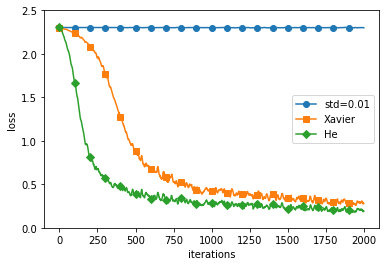

In [8]:
#6.2.4 MNIST 데이터셋으로 본 가중치 초깃값 비교

import os
import sys

sys.path.append(os.pardir)
import numpy as np
import matplotlib.pyplot as plt
from mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD


(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


weight_init_types = {'std=0.01': 0.01, 'Xavier': 'sigmoid', 'He': 'relu'}
optimizer = SGD(lr=0.01)

networks = {}
train_loss = {}
for key, weight_type in weight_init_types.items():
    networks[key] = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100],
                                  output_size=10, weight_init_std=weight_type)
    train_loss[key] = []


for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in weight_init_types.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizer.update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print("===========" + "iteration:" + str(i) + "===========")
        for key in weight_init_types.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


markers = {'std=0.01': 'o', 'Xavier': 's', 'He': 'D'}
x = np.arange(max_iterations)
for key in weight_init_types.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 2.5)
plt.legend()
plt.show()


============== 1/16 ==============
epoch:0 | 0.105 - 0.105


C:\Users\wotj1\common\multi_layer_net_extend.py:101: RuntimeWarning: overflow encountered in square
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)
C:\Users\wotj1\common\multi_layer_net_extend.py:101: RuntimeWarning: invalid value encountered in double_scalars
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)
C:\Users\wotj1\common\functions.py:34: RuntimeWarning: invalid value encountered in subtract
  x = x - np.max(x, axis=0)
C:\Users\wotj1\common\layers.py:12: RuntimeWarning: invalid value encountered in less_equal
  self.mask = (x <= 0)


epoch:1 | 0.097 - 0.088
epoch:2 | 0.097 - 0.108
epoch:3 | 0.097 - 0.133
epoch:4 | 0.097 - 0.148
epoch:5 | 0.097 - 0.165
epoch:6 | 0.097 - 0.188
epoch:7 | 0.097 - 0.197
epoch:8 | 0.097 - 0.216
epoch:9 | 0.097 - 0.25
epoch:10 | 0.097 - 0.259
epoch:11 | 0.097 - 0.275
epoch:12 | 0.097 - 0.288
epoch:13 | 0.097 - 0.301
epoch:14 | 0.097 - 0.321
epoch:15 | 0.097 - 0.339
epoch:16 | 0.097 - 0.365
epoch:17 | 0.097 - 0.377
epoch:18 | 0.097 - 0.384


No handles with labels found to put in legend.


epoch:19 | 0.097 - 0.398
============== 2/16 ==============
epoch:0 | 0.094 - 0.108


C:\Users\wotj1\common\layers.py:12: RuntimeWarning: invalid value encountered in less_equal
  self.mask = (x <= 0)
C:\Users\wotj1\common\multi_layer_net_extend.py:101: RuntimeWarning: overflow encountered in square
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)
C:\Users\wotj1\common\multi_layer_net_extend.py:101: RuntimeWarning: invalid value encountered in double_scalars
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)


epoch:1 | 0.097 - 0.092
epoch:2 | 0.097 - 0.099
epoch:3 | 0.097 - 0.13
epoch:4 | 0.097 - 0.149
epoch:5 | 0.097 - 0.176
epoch:6 | 0.097 - 0.204
epoch:7 | 0.097 - 0.231
epoch:8 | 0.097 - 0.253
epoch:9 | 0.097 - 0.273
epoch:10 | 0.097 - 0.3
epoch:11 | 0.097 - 0.315
epoch:12 | 0.097 - 0.325
epoch:13 | 0.097 - 0.336
epoch:14 | 0.097 - 0.368
epoch:15 | 0.097 - 0.391
epoch:16 | 0.097 - 0.399
epoch:17 | 0.097 - 0.414
epoch:18 | 0.097 - 0.434


No handles with labels found to put in legend.


epoch:19 | 0.097 - 0.458
============== 3/16 ==============
epoch:0 | 0.097 - 0.088
epoch:1 | 0.352 - 0.101
epoch:2 | 0.491 - 0.171
epoch:3 | 0.56 - 0.21
epoch:4 | 0.647 - 0.235
epoch:5 | 0.714 - 0.276
epoch:6 | 0.76 - 0.309
epoch:7 | 0.774 - 0.343
epoch:8 | 0.811 - 0.367
epoch:9 | 0.846 - 0.408
epoch:10 | 0.875 - 0.431
epoch:11 | 0.873 - 0.471
epoch:12 | 0.901 - 0.501
epoch:13 | 0.924 - 0.512
epoch:14 | 0.927 - 0.546
epoch:15 | 0.939 - 0.567
epoch:16 | 0.948 - 0.591
epoch:17 | 0.959 - 0.612
epoch:18 | 0.961 - 0.617


No handles with labels found to put in legend.


epoch:19 | 0.969 - 0.641
============== 4/16 ==============
epoch:0 | 0.096 - 0.132
epoch:1 | 0.23 - 0.145
epoch:2 | 0.374 - 0.196
epoch:3 | 0.46 - 0.26
epoch:4 | 0.53 - 0.347
epoch:5 | 0.591 - 0.404
epoch:6 | 0.625 - 0.47
epoch:7 | 0.646 - 0.533
epoch:8 | 0.687 - 0.576
epoch:9 | 0.707 - 0.638
epoch:10 | 0.737 - 0.67
epoch:11 | 0.747 - 0.695
epoch:12 | 0.767 - 0.718
epoch:13 | 0.783 - 0.739
epoch:14 | 0.798 - 0.75
epoch:15 | 0.809 - 0.763
epoch:16 | 0.824 - 0.785
epoch:17 | 0.825 - 0.794
epoch:18 | 0.83 - 0.803


No handles with labels found to put in legend.


epoch:19 | 0.848 - 0.808
============== 5/16 ==============
epoch:0 | 0.136 - 0.099
epoch:1 | 0.134 - 0.165
epoch:2 | 0.15 - 0.278
epoch:3 | 0.158 - 0.415
epoch:4 | 0.16 - 0.542
epoch:5 | 0.171 - 0.621
epoch:6 | 0.177 - 0.686
epoch:7 | 0.184 - 0.739
epoch:8 | 0.192 - 0.755
epoch:9 | 0.207 - 0.784
epoch:10 | 0.208 - 0.807
epoch:11 | 0.22 - 0.825
epoch:12 | 0.233 - 0.835
epoch:13 | 0.244 - 0.845
epoch:14 | 0.246 - 0.858
epoch:15 | 0.251 - 0.871
epoch:16 | 0.256 - 0.88
epoch:17 | 0.262 - 0.885
epoch:18 | 0.272 - 0.892


No handles with labels found to put in legend.


epoch:19 | 0.274 - 0.901
============== 6/16 ==============
epoch:0 | 0.102 - 0.09
epoch:1 | 0.144 - 0.204
epoch:2 | 0.116 - 0.431
epoch:3 | 0.116 - 0.603
epoch:4 | 0.116 - 0.686
epoch:5 | 0.116 - 0.754
epoch:6 | 0.116 - 0.789
epoch:7 | 0.106 - 0.82
epoch:8 | 0.111 - 0.847
epoch:9 | 0.119 - 0.865
epoch:10 | 0.117 - 0.874
epoch:11 | 0.117 - 0.892
epoch:12 | 0.117 - 0.905
epoch:13 | 0.117 - 0.916
epoch:14 | 0.117 - 0.926
epoch:15 | 0.117 - 0.94
epoch:16 | 0.117 - 0.945
epoch:17 | 0.117 - 0.95
epoch:18 | 0.117 - 0.953


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.958
============== 7/16 ==============
epoch:0 | 0.116 - 0.08
epoch:1 | 0.116 - 0.245
epoch:2 | 0.116 - 0.595
epoch:3 | 0.117 - 0.742
epoch:4 | 0.117 - 0.796
epoch:5 | 0.117 - 0.833
epoch:6 | 0.117 - 0.853
epoch:7 | 0.117 - 0.866
epoch:8 | 0.117 - 0.888
epoch:9 | 0.117 - 0.911
epoch:10 | 0.117 - 0.925
epoch:11 | 0.117 - 0.939
epoch:12 | 0.117 - 0.955
epoch:13 | 0.117 - 0.959
epoch:14 | 0.117 - 0.967
epoch:15 | 0.117 - 0.976
epoch:16 | 0.117 - 0.98
epoch:17 | 0.116 - 0.985
epoch:18 | 0.117 - 0.986


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.987
============== 8/16 ==============
epoch:0 | 0.1 - 0.099
epoch:1 | 0.117 - 0.523
epoch:2 | 0.117 - 0.768
epoch:3 | 0.117 - 0.821
epoch:4 | 0.117 - 0.83
epoch:5 | 0.117 - 0.882
epoch:6 | 0.117 - 0.929
epoch:7 | 0.117 - 0.944
epoch:8 | 0.117 - 0.96
epoch:9 | 0.117 - 0.978
epoch:10 | 0.117 - 0.98
epoch:11 | 0.117 - 0.987
epoch:12 | 0.117 - 0.993
epoch:13 | 0.117 - 0.993
epoch:14 | 0.117 - 0.995
epoch:15 | 0.117 - 0.996
epoch:16 | 0.117 - 0.997
epoch:17 | 0.117 - 0.998
epoch:18 | 0.117 - 0.998


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.998
============== 9/16 ==============
epoch:0 | 0.117 - 0.138
epoch:1 | 0.105 - 0.556
epoch:2 | 0.117 - 0.697
epoch:3 | 0.117 - 0.743
epoch:4 | 0.117 - 0.779
epoch:5 | 0.117 - 0.845
epoch:6 | 0.116 - 0.899
epoch:7 | 0.117 - 0.953
epoch:8 | 0.117 - 0.983
epoch:9 | 0.117 - 0.985
epoch:10 | 0.117 - 0.991
epoch:11 | 0.117 - 0.995
epoch:12 | 0.117 - 0.997
epoch:13 | 0.117 - 0.999
epoch:14 | 0.117 - 0.999
epoch:15 | 0.117 - 0.999
epoch:16 | 0.116 - 0.999
epoch:17 | 0.116 - 0.998
epoch:18 | 0.116 - 0.999


No handles with labels found to put in legend.


epoch:19 | 0.116 - 0.999
============== 10/16 ==============
epoch:0 | 0.099 - 0.137
epoch:1 | 0.117 - 0.713
epoch:2 | 0.117 - 0.801
epoch:3 | 0.117 - 0.835
epoch:4 | 0.117 - 0.922
epoch:5 | 0.117 - 0.942
epoch:6 | 0.117 - 0.975
epoch:7 | 0.117 - 0.982
epoch:8 | 0.117 - 0.99
epoch:9 | 0.117 - 0.995
epoch:10 | 0.117 - 0.995
epoch:11 | 0.117 - 0.978
epoch:12 | 0.117 - 0.995
epoch:13 | 0.117 - 0.994
epoch:14 | 0.117 - 0.996
epoch:15 | 0.117 - 0.998
epoch:16 | 0.117 - 0.999
epoch:17 | 0.117 - 0.999
epoch:18 | 0.117 - 0.999


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.999
============== 11/16 ==============
epoch:0 | 0.094 - 0.174
epoch:1 | 0.117 - 0.628
epoch:2 | 0.117 - 0.688
epoch:3 | 0.117 - 0.758
epoch:4 | 0.117 - 0.786
epoch:5 | 0.117 - 0.784
epoch:6 | 0.117 - 0.783
epoch:7 | 0.117 - 0.85
epoch:8 | 0.117 - 0.889
epoch:9 | 0.117 - 0.876
epoch:10 | 0.117 - 0.88
epoch:11 | 0.117 - 0.891
epoch:12 | 0.117 - 0.903
epoch:13 | 0.117 - 0.919
epoch:14 | 0.117 - 0.989
epoch:15 | 0.117 - 0.991
epoch:16 | 0.117 - 0.992
epoch:17 | 0.117 - 0.99
epoch:18 | 0.117 - 0.997


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.981
============== 12/16 ==============
epoch:0 | 0.117 - 0.204
epoch:1 | 0.117 - 0.625
epoch:2 | 0.117 - 0.706
epoch:3 | 0.117 - 0.635
epoch:4 | 0.117 - 0.733
epoch:5 | 0.117 - 0.782
epoch:6 | 0.117 - 0.78
epoch:7 | 0.117 - 0.863
epoch:8 | 0.117 - 0.858
epoch:9 | 0.117 - 0.87
epoch:10 | 0.117 - 0.877
epoch:11 | 0.117 - 0.867
epoch:12 | 0.117 - 0.877
epoch:13 | 0.117 - 0.89
epoch:14 | 0.117 - 0.891
epoch:15 | 0.117 - 0.888
epoch:16 | 0.117 - 0.897
epoch:17 | 0.117 - 0.899
epoch:18 | 0.117 - 0.897


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.895
============== 13/16 ==============
epoch:0 | 0.093 - 0.241
epoch:1 | 0.116 - 0.56
epoch:2 | 0.116 - 0.583
epoch:3 | 0.116 - 0.592
epoch:4 | 0.116 - 0.629
epoch:5 | 0.117 - 0.665
epoch:6 | 0.117 - 0.614
epoch:7 | 0.116 - 0.637
epoch:8 | 0.117 - 0.684
epoch:9 | 0.117 - 0.655
epoch:10 | 0.117 - 0.706
epoch:11 | 0.116 - 0.708
epoch:12 | 0.116 - 0.703
epoch:13 | 0.116 - 0.703
epoch:14 | 0.117 - 0.561
epoch:15 | 0.117 - 0.705
epoch:16 | 0.117 - 0.709
epoch:17 | 0.116 - 0.711
epoch:18 | 0.116 - 0.71


No handles with labels found to put in legend.


epoch:19 | 0.116 - 0.713
============== 14/16 ==============
epoch:0 | 0.099 - 0.115
epoch:1 | 0.117 - 0.339
epoch:2 | 0.116 - 0.289
epoch:3 | 0.116 - 0.486
epoch:4 | 0.117 - 0.483
epoch:5 | 0.117 - 0.423
epoch:6 | 0.117 - 0.502
epoch:7 | 0.117 - 0.503
epoch:8 | 0.117 - 0.518
epoch:9 | 0.117 - 0.519
epoch:10 | 0.117 - 0.528
epoch:11 | 0.117 - 0.516
epoch:12 | 0.117 - 0.491
epoch:13 | 0.117 - 0.52
epoch:14 | 0.117 - 0.543
epoch:15 | 0.117 - 0.592
epoch:16 | 0.117 - 0.588
epoch:17 | 0.117 - 0.496
epoch:18 | 0.117 - 0.611


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.619
============== 15/16 ==============
epoch:0 | 0.117 - 0.091
epoch:1 | 0.117 - 0.227
epoch:2 | 0.117 - 0.394
epoch:3 | 0.117 - 0.376
epoch:4 | 0.117 - 0.344
epoch:5 | 0.117 - 0.41
epoch:6 | 0.117 - 0.411
epoch:7 | 0.117 - 0.41
epoch:8 | 0.117 - 0.416
epoch:9 | 0.117 - 0.414
epoch:10 | 0.117 - 0.419
epoch:11 | 0.117 - 0.411
epoch:12 | 0.117 - 0.426
epoch:13 | 0.117 - 0.432
epoch:14 | 0.117 - 0.424
epoch:15 | 0.117 - 0.432
epoch:16 | 0.117 - 0.431
epoch:17 | 0.117 - 0.431
epoch:18 | 0.117 - 0.432


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.432
============== 16/16 ==============
epoch:0 | 0.097 - 0.097
epoch:1 | 0.116 - 0.34
epoch:2 | 0.116 - 0.191
epoch:3 | 0.116 - 0.385
epoch:4 | 0.116 - 0.484
epoch:5 | 0.116 - 0.495
epoch:6 | 0.117 - 0.506
epoch:7 | 0.117 - 0.489
epoch:8 | 0.117 - 0.507
epoch:9 | 0.117 - 0.503
epoch:10 | 0.117 - 0.507
epoch:11 | 0.117 - 0.408
epoch:12 | 0.117 - 0.498
epoch:13 | 0.117 - 0.501
epoch:14 | 0.117 - 0.509
epoch:15 | 0.117 - 0.503
epoch:16 | 0.117 - 0.228
epoch:17 | 0.117 - 0.502
epoch:18 | 0.117 - 0.506
epoch:19 | 0.117 - 0.582


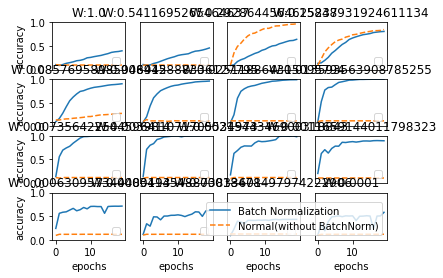

In [20]:
# 6.3.2 배치 정규화의 효과

import sys, os
sys.path.append(os.pardir)
import numpy as np
import matplotlib.pyplot as plt
from mnist import load_mnist
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.optimizer import SGD, Adam

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

x_train = x_train[:1000]
t_train = t_train[:1000]

max_epochs = 20
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01


def __train(weight_init_std):
    bn_network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10, 
                                    weight_init_std=weight_init_std, use_batchnorm=True)
    network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10,
                                weight_init_std=weight_init_std)
    optimizer = SGD(lr=learning_rate)
    
    train_acc_list = []
    bn_train_acc_list = []
    
    iter_per_epoch = max(train_size / batch_size, 1)
    epoch_cnt = 0
    
    for i in range(1000000000):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]
    
        for _network in (bn_network, network):
            grads = _network.gradient(x_batch, t_batch)
            optimizer.update(_network.params, grads)
    
        if i % iter_per_epoch == 0:
            train_acc = network.accuracy(x_train, t_train)
            bn_train_acc = bn_network.accuracy(x_train, t_train)
            train_acc_list.append(train_acc)
            bn_train_acc_list.append(bn_train_acc)
    
            print("epoch:" + str(epoch_cnt) + " | " + str(train_acc) + " - " + str(bn_train_acc))
    
            epoch_cnt += 1
            if epoch_cnt >= max_epochs:
                break
                
    return train_acc_list, bn_train_acc_list


weight_scale_list = np.logspace(0, -4, num=16)
x = np.arange(max_epochs)

for i, w in enumerate(weight_scale_list):
    print( "============== " + str(i+1) + "/16" + " ==============")
    train_acc_list, bn_train_acc_list = __train(w)
    
    plt.subplot(4,4,i+1)
    plt.title("W:" + str(w))
    if i == 15:
        plt.plot(x, bn_train_acc_list, label='Batch Normalization', markevery=2)
        plt.plot(x, train_acc_list, linestyle = "--", label='Normal(without BatchNorm)', markevery=2)
    else:
        plt.plot(x, bn_train_acc_list, markevery=2)
        plt.plot(x, train_acc_list, linestyle="--", markevery=2)

    plt.ylim(0, 1.0)
    if i % 4:
        plt.yticks([])
    else:
        plt.ylabel("accuracy")
    if i < 12:
        plt.xticks([])
    else:
        plt.xlabel("epochs")
    plt.legend(loc='lower right')
    
plt.show()

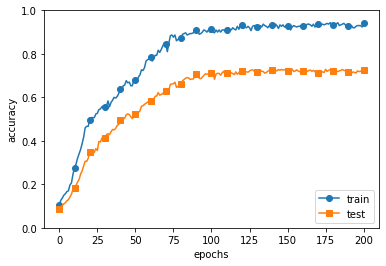

In [23]:
# 6.4.1 오버피팅

import os
import sys

sys.path.append(os.pardir)
import numpy as np
import matplotlib.pyplot as plt
from mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 오버피팅을 재현하기 위해 학습 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]

weight_decay_lambda = 0.1

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10,
                        weight_decay_lambda=weight_decay_lambda)
optimizer = SGD(lr=0.01)   # 학습률이 0.01인 SGD로 매개변수 갱신

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000):    #교재 내용보다 반복 횟 수 줄여서 비교해보기
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break


# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()


In [ ]:
# 6.4.3 드롭아웃

class Dropout:
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None
        
    def forward(self, x, train_flg=True):
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * (1.0 - self.dropout_ratio)
        
    def backward(self, dout):
        return dout * self.mask

train loss:2.305387576038811
=== epoch:1, train acc:0.09, test acc:0.0959 ===
train loss:2.328816930558081
train loss:2.321872630249502
train loss:2.299457016884817
=== epoch:2, train acc:0.09, test acc:0.0956 ===
train loss:2.2741493199024174
train loss:2.313465729800751
train loss:2.30643698305076
=== epoch:3, train acc:0.09, test acc:0.0957 ===
train loss:2.301911321456008
train loss:2.2732551354804804
train loss:2.287875343451119
=== epoch:4, train acc:0.09, test acc:0.0956 ===
train loss:2.3011274962626964
train loss:2.3098013698765634
train loss:2.2885810356727383
=== epoch:5, train acc:0.09, test acc:0.0956 ===
train loss:2.276984915248077
train loss:2.298183449612665
train loss:2.303708648006175
=== epoch:6, train acc:0.09, test acc:0.0957 ===
train loss:2.3139410749149594
train loss:2.284502696318426
train loss:2.2762778264744274
=== epoch:7, train acc:0.09, test acc:0.0953 ===
train loss:2.296113568009857
train loss:2.28483930378639
train loss:2.2816341705170435
=== epoch:8, 

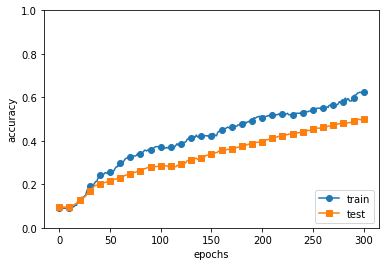

In [25]:
import os
import sys
sys.path.append(os.pardir)  
import numpy as np
import matplotlib.pyplot as plt
from mnist import load_mnist
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)


x_train = x_train[:300]
t_train = t_train[:300]

use_dropout = True  
dropout_ratio = 0.2


network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                              output_size=10, use_dropout=use_dropout, dropout_ration=dropout_ratio)
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=301, mini_batch_size=100,
                  optimizer='sgd', optimizer_param={'lr': 0.01}, verbose=True)
trainer.train()

train_acc_list, test_acc_list = trainer.train_acc_list, trainer.test_acc_list

markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

In [26]:
# 6.5.1 검증 데이터

def shuffle_dataset(x, t):
    permutation = np.random.permutation(x.shape[0])
    x = x[permutation,:] if x.ndim == 2 else x[permutation,:,:,:]
    t = t[permutation]
    
    return x, t

In [27]:
(x_train, t_train), (x_test, t_test) = load_mnist()

# 훈련 데이터를 뒤섞는다.
x_train, t_train = shuffle_dataset(x_train, t_train)

# 20%를 검증 데이터로 분할
validation_rate = 0.20
validation_num = int(x_train.shape[0] * validation_rate)

x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]


In [28]:
# 6.5.3 하이퍼파라미터 최적화 구현하기

weight_decay = 10**np.random.uniform(-8, -4)
lr = 10 ** np.random.uniform(-6, -2)

val acc:0.09 | lr:0.0002156013403998962, weight decay:3.847236725121695e-08
val acc:0.08 | lr:8.21780707520943e-05, weight decay:1.2169346685606924e-08
val acc:0.1 | lr:3.7333254431414796e-05, weight decay:5.1368305743040804e-06
val acc:0.13 | lr:0.0005989441246055422, weight decay:2.2763302863891256e-08
val acc:0.06 | lr:4.744620254985575e-06, weight decay:4.080261195025185e-05
val acc:0.31 | lr:0.0007725749282137901, weight decay:3.24414212907173e-05
val acc:0.17 | lr:0.0007028808989674064, weight decay:3.9124750993668896e-06
val acc:0.13 | lr:0.00024691282948242893, weight decay:3.1369652408614646e-06
val acc:0.49 | lr:0.0043931631990675275, weight decay:7.078960020795275e-05
val acc:0.1 | lr:8.044323969825057e-06, weight decay:1.1950958132721e-05
val acc:0.15 | lr:0.0003440164049118898, weight decay:3.345908718936707e-08
val acc:0.04 | lr:2.9223070963593594e-05, weight decay:1.2867444730619975e-06
val acc:0.34 | lr:0.0025769517418161108, weight decay:7.5229521751156976e-06
val acc:

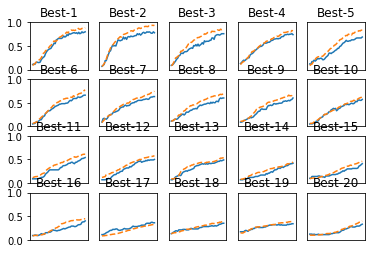

In [30]:
import sys, os
sys.path.append(os.pardir) 
import numpy as np
import matplotlib.pyplot as plt
from mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.util import shuffle_dataset
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

x_train = x_train[:500]
t_train = t_train[:500]

validation_rate = 0.20
validation_num = int(x_train.shape[0] * validation_rate)
x_train, t_train = shuffle_dataset(x_train, t_train)
x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]


def __train(lr, weight_decay, epocs=50):
    network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                            output_size=10, weight_decay_lambda=weight_decay)
    trainer = Trainer(network, x_train, t_train, x_val, t_val,
                      epochs=epocs, mini_batch_size=100,
                      optimizer='sgd', optimizer_param={'lr': lr}, verbose=False)
    trainer.train()

    return trainer.test_acc_list, trainer.train_acc_list


optimization_trial = 100
results_val = {}
results_train = {}
for _ in range(optimization_trial):
    weight_decay = 10 ** np.random.uniform(-8, -4)
    lr = 10 ** np.random.uniform(-6, -2)

    val_acc_list, train_acc_list = __train(lr, weight_decay)
    print("val acc:" + str(val_acc_list[-1]) + " | lr:" + str(lr) + ", weight decay:" + str(weight_decay))
    key = "lr:" + str(lr) + ", weight decay:" + str(weight_decay)
    results_val[key] = val_acc_list
    results_train[key] = train_acc_list

print("=========== Hyper-Parameter Optimization Result ===========")
graph_draw_num = 20
col_num = 5
row_num = int(np.ceil(graph_draw_num / col_num))
i = 0

for key, val_acc_list in sorted(results_val.items(), key=lambda x:x[1][-1], reverse=True):
    print("Best-" + str(i+1) + "(val acc:" + str(val_acc_list[-1]) + ") | " + key)

    plt.subplot(row_num, col_num, i+1)
    plt.title("Best-" + str(i+1))
    plt.ylim(0.0, 1.0)
    if i % 5: plt.yticks([])
    plt.xticks([])
    x = np.arange(len(val_acc_list))
    plt.plot(x, val_acc_list)
    plt.plot(x, results_train[key], "--")
    i += 1

    if i >= graph_draw_num:
        break

plt.show()